# Univariate CNN example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt

Separate a multivariate sequence into samples

In [2]:
def split_sequence(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps
        # Check if we are bound by sequence
        if end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Load the data

In [3]:
df = pd.read_csv("SP500.csv")

Show the data

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [5]:
start_date = df.Date.min()
end_date = df.Date.max()

In [6]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [8]:
df = df.interpolate(method='linear', limit_direction='both')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,7.755000e+05,0.0,0.0
1,2000-05-20,95.642869,95.642869,93.713029,94.583211,1.133867e+06,0.0,0.0
2,2000-05-21,95.179710,95.179710,92.941096,94.386721,1.492233e+06,0.0,0.0
3,2000-05-22,94.716551,94.716551,92.169162,94.190231,1.850600e+06,0.0,0.0
4,2000-05-23,94.463952,94.463952,92.758675,92.758675,3.739000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...
7784,2021-09-10,453.059998,453.510010,447.299988,447.540009,3.023500e+06,0.0,0.0
7785,2021-09-11,452.266663,452.650004,446.896657,447.886668,3.018133e+06,0.0,0.0
7786,2021-09-12,451.473328,451.789998,446.493327,448.233327,3.012767e+06,0.0,0.0
7787,2021-09-13,450.679993,450.929993,446.089996,448.579987,3.007400e+06,0.0,0.0


Define input sequence

In [9]:
raw_seq = np.array(df.Close)

Choose a number of time steps

In [10]:
n_steps = 3
n_features = 1

Convert into input/output

In [11]:
X, y = split_sequence(raw_seq, n_steps)

Reshape from [samples, timesteps] into [samples, timesteps, features]

In [12]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

Set test data

In [13]:
test_size = n_steps
prediction_size = n_features
y_test = y[-test_size-prediction_size:-prediction_size]
X_test = raw_seq[-test_size-prediction_size:-prediction_size]
X_test = X_test.reshape((1, test_size, n_features))

In [14]:
y_expected = y[-prediction_size:]

In [15]:
y = y[:-test_size-prediction_size]
X = X[:-test_size-prediction_size]

Define model

In [16]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [17]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [18]:
model.fit(X, y, epochs=1000)

Epoch 1/1000
244/244 [==============================] - 0s 475us/step - loss: 2898.9722
Epoch 2/1000
244/244 [==============================] - 0s 481us/step - loss: 3.6597
Epoch 3/1000
244/244 [==============================] - 0s 470us/step - loss: 3.6931
Epoch 4/1000
244/244 [==============================] - 0s 456us/step - loss: 3.6945
Epoch 5/1000
244/244 [==============================] - 0s 459us/step - loss: 3.7098
Epoch 6/1000
244/244 [==============================] - 0s 463us/step - loss: 3.7018
Epoch 7/1000
244/244 [==============================] - 0s 467us/step - loss: 3.6922
Epoch 8/1000
244/244 [==============================] - 0s 479us/step - loss: 3.7124
Epoch 9/1000
244/244 [==============================] - 0s 458us/step - loss: 3.7036
Epoch 10/1000
244/244 [==============================] - 0s 455us/step - loss: 3.7479
Epoch 11/1000
244/244 [==============================] - 0s 456us/step - loss: 3.6795
Epoch 12/1000
244/244 [==============================] - 0s 

244/244 [==============================] - 0s 440us/step - loss: 2.7419
Epoch 191/1000
244/244 [==============================] - 0s 446us/step - loss: 2.9382
Epoch 192/1000
244/244 [==============================] - 0s 439us/step - loss: 2.8779
Epoch 193/1000
244/244 [==============================] - 0s 435us/step - loss: 3.0911
Epoch 194/1000
244/244 [==============================] - 0s 449us/step - loss: 3.0182
Epoch 195/1000
244/244 [==============================] - 0s 452us/step - loss: 2.9006
Epoch 196/1000
244/244 [==============================] - 0s 463us/step - loss: 2.6897
Epoch 197/1000
244/244 [==============================] - 0s 467us/step - loss: 3.4342
Epoch 198/1000
244/244 [==============================] - 0s 463us/step - loss: 3.0426
Epoch 199/1000
244/244 [==============================] - 0s 581us/step - loss: 2.9934
Epoch 200/1000
244/244 [==============================] - 0s 433us/step - loss: 2.9025
Epoch 201/1000
244/244 [==============================] - 

244/244 [==============================] - 0s 480us/step - loss: 2.6950
Epoch 379/1000
244/244 [==============================] - 0s 461us/step - loss: 2.7444
Epoch 380/1000
244/244 [==============================] - 0s 477us/step - loss: 2.8222
Epoch 381/1000
244/244 [==============================] - 0s 476us/step - loss: 2.7521
Epoch 382/1000
244/244 [==============================] - 0s 454us/step - loss: 2.7269
Epoch 383/1000
244/244 [==============================] - 0s 452us/step - loss: 3.0652
Epoch 384/1000
244/244 [==============================] - 0s 474us/step - loss: 2.7628
Epoch 385/1000
244/244 [==============================] - 0s 459us/step - loss: 2.7416
Epoch 386/1000
244/244 [==============================] - 0s 449us/step - loss: 2.7254
Epoch 387/1000
244/244 [==============================] - 0s 463us/step - loss: 2.7221
Epoch 388/1000
244/244 [==============================] - 0s 467us/step - loss: 2.6863
Epoch 389/1000
244/244 [==============================] - 

244/244 [==============================] - 0s 459us/step - loss: 2.8288
Epoch 567/1000
244/244 [==============================] - 0s 451us/step - loss: 2.8520
Epoch 568/1000
244/244 [==============================] - 0s 450us/step - loss: 2.6241
Epoch 569/1000
244/244 [==============================] - 0s 464us/step - loss: 3.0637
Epoch 570/1000
244/244 [==============================] - 0s 483us/step - loss: 2.7220
Epoch 571/1000
244/244 [==============================] - 0s 456us/step - loss: 2.9417
Epoch 572/1000
244/244 [==============================] - 0s 460us/step - loss: 2.5989
Epoch 573/1000
244/244 [==============================] - 0s 459us/step - loss: 2.6207
Epoch 574/1000
244/244 [==============================] - 0s 485us/step - loss: 2.7100
Epoch 575/1000
244/244 [==============================] - 0s 454us/step - loss: 2.6626
Epoch 576/1000
244/244 [==============================] - 0s 453us/step - loss: 2.9249
Epoch 577/1000
244/244 [==============================] - 

244/244 [==============================] - 0s 469us/step - loss: 2.9169
Epoch 755/1000
244/244 [==============================] - 0s 456us/step - loss: 2.8037
Epoch 756/1000
244/244 [==============================] - 0s 464us/step - loss: 2.8062
Epoch 757/1000
244/244 [==============================] - 0s 474us/step - loss: 2.8817
Epoch 758/1000
244/244 [==============================] - 0s 463us/step - loss: 2.7981
Epoch 759/1000
244/244 [==============================] - 0s 459us/step - loss: 2.5528
Epoch 760/1000
244/244 [==============================] - 0s 490us/step - loss: 2.7445
Epoch 761/1000
244/244 [==============================] - 0s 473us/step - loss: 2.9534
Epoch 762/1000
244/244 [==============================] - 0s 536us/step - loss: 2.9394
Epoch 763/1000
244/244 [==============================] - 0s 469us/step - loss: 3.0976
Epoch 764/1000
244/244 [==============================] - 0s 484us/step - loss: 2.7199
Epoch 765/1000
244/244 [==============================] - 

244/244 [==============================] - 0s 461us/step - loss: 2.8825
Epoch 943/1000
244/244 [==============================] - 0s 467us/step - loss: 2.8907
Epoch 944/1000
244/244 [==============================] - 0s 463us/step - loss: 2.6696
Epoch 945/1000
244/244 [==============================] - 0s 449us/step - loss: 2.7882
Epoch 946/1000
244/244 [==============================] - 0s 443us/step - loss: 2.7631
Epoch 947/1000
244/244 [==============================] - 0s 493us/step - loss: 2.8044
Epoch 948/1000
244/244 [==============================] - 0s 452us/step - loss: 2.6477
Epoch 949/1000
244/244 [==============================] - 0s 481us/step - loss: 2.7443
Epoch 950/1000
244/244 [==============================] - 0s 471us/step - loss: 2.7752
Epoch 951/1000
244/244 [==============================] - 0s 446us/step - loss: 2.8932
Epoch 952/1000
244/244 [==============================] - 0s 452us/step - loss: 2.7913
Epoch 953/1000
244/244 [==============================] - 

Demonstrate prediction

In [19]:
yhat = model.predict(X)

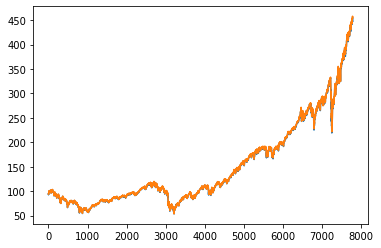

In [20]:
plt.plot(y)
plt.plot(yhat)
plt.show()

Demonstrate prediction

In [21]:
yhat = model.predict(X_test)

In [22]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {y_expected[0]:.2f}")

Predicted: 450.92  Expected: 446.19


**THIS IS NOT AN INVESTMENT ADVICE!**